# UK Retail dataset

Here we will focus on prediction engineering. Prediction engineering is a step in predictive modeling where we: 
* Define an outome we are interested in predicting 
* Scan the data to find the past occurences of the outcome 
* Make these past occurences training examples for machine learning/modeling

We will then use featuretools to extract features and learn a predictive model.
In this particular casestudy, we are focusing a retail dataset openly available at http://archive.ics.uci.edu/ml/datasets/online+retail
We will define the prediction problem as the one where the customer has more than k purchases

In [27]:
import featuretools as ft
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
ft.__version__

'0.9.1'

## Loading the data

Taking a sneak peak to one of the 'csv' files to see its structure

In [29]:
# Function to read and format the data inside the csv files
def load_uk_retail_data():
    item_purchases = pd.read_csv('Data/item_purchases.csv', encoding = 'unicode_escape')
    invoices = pd.read_csv('Data/invoices.csv', encoding = 'unicode_escape') 
    items = pd.read_csv('Data/items.csv', encoding = 'unicode_escape')
    customers = pd.read_csv('Data/customers.csv', encoding = 'unicode_escape')
    invoices['first_item_purchases_time'] = pd.to_datetime(
        invoices['first_item_purchases_time'], format="%m/%d/%y %H:%M")
    item_purchases['InvoiceDate'] = pd.to_datetime(
        item_purchases['InvoiceDate'], format="%m/%d/%y %H:%M")
    customers['first_invoices_time'] = pd.to_datetime(
        customers['first_invoices_time'], format="%m/%d/%y %H:%M")
    items['first_item_purchases_time'] = pd.to_datetime(
        items['first_item_purchases_time'], format="%m/%d/%y %H:%M")
    return item_purchases, invoices, items, customers

In [30]:
item_purchases, invoices, items, customers = load_uk_retail_data()

In [31]:
invoices = pd.read_csv('Data/invoices.csv', encoding = 'unicode_escape') 
# In order to avoid utf-8 codec error, the encoding should be set when reading the csv file
invoices.head()

,InvoiceNo,CustomerID,first_item_purchases_time
0,536365,17850.0,12/1/10 8:26
1,536366,17850.0,12/1/10 8:28
2,536367,13047.0,12/1/10 8:34
3,536368,13047.0,12/1/10 8:34
4,536369,13047.0,12/1/10 8:35


In [52]:
item_purchases.head()

,item_purchase_id,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice
0,0,536365,85123A,6,2010-12-01 08:26:00,2.55
1,1,536365,71053,6,2010-12-01 08:26:00,3.39
2,2,536365,84406B,8,2010-12-01 08:26:00,2.75
3,3,536365,84029G,6,2010-12-01 08:26:00,3.39
4,4,536365,84029E,6,2010-12-01 08:26:00,3.39


In [54]:
items.head()

,StockCode,Description,first_item_purchases_time
0,21730,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01 08:26:00
1,22752,SET 7 BABUSHKA NESTING BOXES,2010-12-01 08:26:00
2,71053,WHITE METAL LANTERN,2010-12-01 08:26:00
3,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00
4,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00


In [55]:
customers.head()

,CustomerID,Country,first_invoices_time
0,17850.0,United Kingdom,2010-12-01 08:26:00
1,13047.0,United Kingdom,2010-12-01 08:34:00
2,12583.0,France,2010-12-01 08:45:00
3,13748.0,United Kingdom,2010-12-01 09:00:00
4,15100.0,United Kingdom,2010-12-01 09:09:00


## Shape of the datasets

In [49]:
print(item_purchases.shape, invoices.shape, items.shape, customers.shape)

(541909, 6) (25900, 3) (4070, 3) (4373, 3)


Now, let's see how many missing data we have for each one of the datasets

In [51]:
print(f'Number of missing data for: \n"item_purchases":\n{item_purchases.isna().sum()}')
print('*'*50)
print(f'Number of missing data for: \n"invoices":\n{invoices.isna().sum()}')
print('*'*50)
print(f'Number of missing data for: \n"items":\n{items.isna().sum()}')
print('*'*50)
print(f'Number of missing data for: \n"customers":\n{customers.isna().sum()}')
print('*'*50)

Number of missing data for: 
"item_purchases":
item_purchase_id    0
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
dtype: int64
**************************************************
Number of missing data for: 
"invoices":
InvoiceNo                       0
CustomerID                   3710
first_item_purchases_time       0
dtype: int64
**************************************************
Number of missing data for: 
"items":
StockCode                      0
Description                  176
first_item_purchases_time      0
dtype: int64
**************************************************
Number of missing data for: 
"customers":
CustomerID             1
Country                0
first_invoices_time    0
dtype: int64
**************************************************


From our simple EDA, we already see that there are many missing values in the 'invoice' dataset. One can simply think on making those values equal to zero, however the number of missing entries are considerable and such approach can lead to a bad estimation or, even, a overfitting of a future model.

## Visualization

<BarContainer object of 4373 artists>

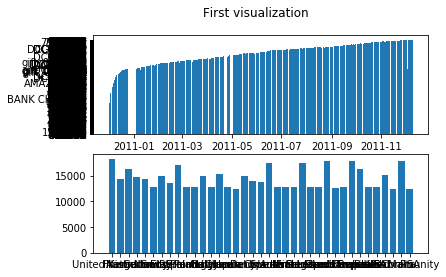

In [65]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('First visualization')
ax1.bar(item_purchases['InvoiceDate'], item_purchases['StockCode'])
ax2.bar(customers['Country'], customers['CustomerID'])

## Preparing the data

In [66]:
# Entities and relationships betwen the datasets to be enter as parameters into featuretools 
entities = {
            "item_purchases": (item_purchases, "item_purchase_id", "InvoiceDate" ),
            "items": (items, "StockCode"),
            "customers": (customers,"CustomerID"),
            "invoices":(invoices,"InvoiceNo", "first_item_purchases_time")
            }
relationships = [("customers", "CustomerID","invoices", "CustomerID"),
                 ("invoices", "InvoiceNo","item_purchases", "InvoiceNo"),
                 ("items", "StockCode","item_purchases", "StockCode")]

In [67]:
def find_training_examples(item_purchases, invoices, prediction_window,
                           training_window, lead, threshold):
    niter = 2  # hard coded number of cutoffs we will search starting with
    cutoff_time = pd.Timestamp("2011-05-01")  # hard coded start date
    label_times = pd.DataFrame()
    for k in range(1, niter):
        cutoff_time = cutoff_time + pd.Timedelta("45d")
        lt = make_label_times(item_purchases, invoices, cutoff_time,
                              prediction_window,
                              training_window, lead, threshold)
        label_times = label_times.append(lt)

    label_times = label_times.sort_values('cutoff_time')
    return label_times

In [69]:
def make_label_times(item_purchases, invoices, cutoff_time, prediction_window,
                     training_window, lead, threshold):
    data = item_purchases.merge(
        invoices)[["CustomerID", "InvoiceDate", "Quantity", "UnitPrice"]]
    data["amount"] = data["Quantity"] * data["UnitPrice"]

    prediction_window_start = cutoff_time
    prediction_window_end = cutoff_time + prediction_window
    cutoff_time = cutoff_time - lead
    t_start = cutoff_time - training_window

    training_data = data[(data["InvoiceDate"] <= cutoff_time) &
                         (data["InvoiceDate"] > t_start)]
    prediction_data = data[(data["InvoiceDate"] > prediction_window_start) & (
        data["InvoiceDate"] < prediction_window_end)]

    # get customers in training data
    label_times = pd.DataFrame()
    label_times["CustomerID"] = training_data["CustomerID"].dropna().unique()
    label_times["t_start"] = t_start
    label_times["cutoff_time"] = cutoff_time

    labels = prediction_data.groupby("CustomerID")[["amount"]].count()

    label_times = label_times.merge(
        labels, how="left", left_on="CustomerID", right_index=True)

    # if the amount is nan that means the customer made no purchases in
    # prediction window
    label_times["amount"] = label_times["amount"].fillna(0)
    label_times.rename(columns={"amount": "purchases>threshold"}, inplace=True)
    label_times['purchases>threshold'] = label_times['purchases>threshold'] \
        > threshold

    return label_times



In [70]:
def preview(df, n=5):
    """return n rows that have fewest number of nulls"""
    order = df.isnull().sum(axis=1).sort_values(kind='mergesort').head(n).index
    return df.loc[order]


def feature_importances(model, feature_names, n=10):
    importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i + 1, f[0], f[1]))

In [71]:
label_times = find_training_examples(item_purchases, invoices,
                                     prediction_window=pd.Timedelta("14d"),
                                     training_window=pd.Timedelta("21d"),
                                     lead=pd.Timedelta("7d"),
                                     threshold=5)

In [72]:
preview(label_times, 5)

,CustomerID,t_start,cutoff_time,purchases>threshold
0,17505.0,2011-05-18,2011-06-08,False
516,16444.0,2011-05-18,2011-06-08,False
517,16889.0,2011-05-18,2011-06-08,False
518,17613.0,2011-05-18,2011-06-08,True
519,17152.0,2011-05-18,2011-06-08,False


In the output above, we are showing the first 5 training examples. The first column is the CustomerID, the second column is the timestamp after which we can use the data for generating features. The third column is the last timestamp we can use the data from the customer. The fourth column is the label. It is True if the customer had more than 5 purchases in the period between (cutoff_time, cutoff_time + prediction_window)

## Generating features

In [78]:
from featuretools.primitives import (Day, Hour, Max, Mean, Min, Minute, Month, Skew, Std, Week, Weekday)

def engineer_features_uk_retail(entities, relationships, label_times,
                                training_window):
    trans_primitives = [Minute, Hour, Day, Week, Month, Weekday]

    es = ft.EntitySet("entityset",
                      entities=entities,
                      relationships=relationships)

    es.add_last_time_indexes()

    feature_matrix, features = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      trans_primitives=trans_primitives,
                                      agg_primitives=[Mean, Max, Std],
                                      cutoff_time=label_times[[
                                          "CustomerID", "cutoff_time"]],
                                      training_window=training_window)
    feature_matrix.drop("Country", axis=1, inplace=True)
    feature_matrix = feature_matrix.sort_index()
    return feature_matrix

feature_matrix = engineer_features_uk_retail(entities, relationships,
                                                     label_times, training_window='21d')

preview(feature_matrix, 10)

,MEAN(item_purchases.Quantity),MEAN(item_purchases.UnitPrice),MAX(item_purchases.Quantity),MAX(item_purchases.UnitPrice),STD(item_purchases.Quantity),STD(item_purchases.UnitPrice),MINUTE(first_invoices_time),HOUR(first_invoices_time),DAY(first_invoices_time),WEEK(first_invoices_time),...,MAX(invoices.MEAN(item_purchases.Quantity)),MAX(invoices.MEAN(item_purchases.UnitPrice)),MAX(invoices.STD(item_purchases.Quantity)),MAX(invoices.STD(item_purchases.UnitPrice)),MAX(invoices.MINUTE(first_item_purchases_time)),STD(invoices.MEAN(item_purchases.Quantity)),STD(invoices.MEAN(item_purchases.UnitPrice)),STD(invoices.MAX(item_purchases.Quantity)),STD(invoices.MAX(item_purchases.UnitPrice)),STD(invoices.MINUTE(first_item_purchases_time))
CustomerID,,,,,,,,,,,,,,,,,,,,,
12423.0,8.074074,3.707407,24,15.00,4.999430,4.368663,54,10,21,51,...,11.400000,3.864000,8.234076,6.238700,48,2.886281,0.135893,8.485281,0.000000,15.556349
12431.0,10.850000,4.032000,84,8.95,19.746485,3.032795,3,10,1,48,...,13.588235,4.900000,20.230110,5.727565,57,10.778412,1.688579,50.846173,4.214657,21.825062
12437.0,16.000000,5.240000,48,18.00,14.000000,5.824917,13,14,12,2,...,16.545455,5.310000,14.888678,6.299767,34,0.809959,0.094495,5.656854,0.000000,18.384776
12464.0,3.000000,11.408333,6,16.95,1.549193,5.825926,30,13,3,5,...,3.500000,12.862500,1.732051,6.936182,49,1.060660,3.084753,2.828427,5.975052,0.707107
12473.0,11.255814,2.638605,48,18.00,15.485928,4.366770,15,10,1,22,...,15.914286,18.000000,12.403442,3.993034,37,13.330432,9.382885,28.583212,8.689122,11.930353
12474.0,-0.300000,2.446000,12,4.95,4.498148,1.384985,0,12,6,49,...,12.000000,2.732500,1.732051,1.479603,48,7.875331,1.159797,7.505553,2.482606,14.047538
12481.0,11.795455,2.619545,25,18.00,6.356025,3.365033,13,10,9,49,...,12.857143,2.808919,6.618406,3.642809,27,0.892756,0.841703,0.707107,11.349064,0.707107
12493.0,6.692308,6.000000,12,18.00,4.404252,6.609778,53,14,26,21,...,7.333333,16.950000,3.915780,5.987681,53,5.892557,8.388054,9.192388,0.742462,5.656854
12540.0,11.157143,4.252000,40,28.00,8.393641,5.553142,39,9,13,50,...,12.936170,5.591739,8.486317,6.658208,32,3.828581,1.410930,10.606602,0.000000,6.363961


## Let’s train a model using Random Forests

* First split our training examples in train_test_split 
* Impute missing values 
* Train a model using training data 
* Test on the data set aside for testing

In [89]:
from sklearn.model_selection import train_test_split
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import SimpleImputer, IterativeImputer
import numpy as np

# set global random seed
np.random.seed(40)

label_times[["CustomerID"]]
X_y = feature_matrix.merge(label_times[["CustomerID", 'purchases>threshold']],
                                   right_on="CustomerID", left_index=True)
y = X_y.pop('purchases>threshold')
X_train, X_test, y_train, y_test = train_test_split(feature_matrix,
                                                            y, test_size=0.35)

We can impute the missing values or NaN values in the feature_matrix using the Imputer in scikit-learn. It replaces the NaN values in a feature column with the mean of the rest of the entries in that column. This is a simple imputation startegy

In [97]:
from sklearn.ensemble import ExtraTreesRegressor

simple_imp = SimpleImputer(missing_values=np.nan, strategy='mean', fill_value=None)
iterative_imp = IterativeImputer(random_state=0, 
                                 initial_strategy = 'most_frequent', 
                                 estimator=ExtraTreesRegressor(n_estimators=10, 
                                                               random_state=0)
                                )

simple_imp = simple_imp.fit(X_train)
iterative_imp = iterative_imp.fit(X_train)


X_train_simple_imp = simple_imp.transform(X_train)
X_train_iterative_imp = iterative_imp.transform(X_train)

/Users/wagner/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [98]:
clf = RandomForestClassifier(random_state=0, n_estimators=100,
                                      class_weight="balanced", verbose=True)
clf.fit(X_train_simple_imp, y_train)
clf.fit(X_train_iterative_imp, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=0, verbose=True, warm_start=False)

## Test the models

To test a model, we: 
* First impute the missing values 
* Use the trained classifier to predict the labels

In [99]:
X_test_simple_imp = simple_imp.transform(X_test)
X_test_iterative_imp = iterative_imp.transform(X_test)

predicted_labels_simple = clf.predict(X_test_simple_imp)
predicted_labels_iterative = clf.predict(X_test_iterative_imp)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [103]:
tn_s, fp_s, fn_s, tp_s = confusion_matrix(y_test, predicted_labels_simple).ravel()
tn_i, fp_i, fn_i, tp_i = confusion_matrix(y_test, predicted_labels_iterative).ravel()

In [104]:
tn_s, fp_s, fn_s, tp_s

(225, 1, 48, 1)

In [105]:
tn_i, fp_i, fn_i, tp_i

(225, 1, 47, 2)

In [106]:
confusion_matrix(y_test, predicted_labels_iterative)

array([[225,   1],
       [ 47,   2]])

In [108]:
confusion_matrix(y_test, predicted_labels_simple)

array([[225,   1],
       [ 48,   1]])

In [109]:
feature_importances(clf, feature_matrix.columns, n=15)

1: Feature: STD(invoices.MINUTE(first_item_purchases_time)), 0.069
2: Feature: STD(invoices.MAX(item_purchases.UnitPrice)), 0.051
3: Feature: STD(invoices.MEAN(item_purchases.UnitPrice)), 0.047
4: Feature: WEEK(first_invoices_time), 0.044
5: Feature: MEAN(invoices.MINUTE(first_item_purchases_time)), 0.043
6: Feature: MAX(invoices.MINUTE(first_item_purchases_time)), 0.040
7: Feature: MEAN(invoices.MEAN(item_purchases.Quantity)), 0.040
8: Feature: STD(invoices.MEAN(item_purchases.Quantity)), 0.039
9: Feature: MEAN(item_purchases.UnitPrice), 0.039
10: Feature: MONTH(first_invoices_time), 0.037
11: Feature: STD(item_purchases.UnitPrice), 0.037
12: Feature: DAY(first_invoices_time), 0.035
13: Feature: STD(invoices.MAX(item_purchases.Quantity)), 0.035
14: Feature: MAX(invoices.MEAN(item_purchases.Quantity)), 0.032
15: Feature: MAX(invoices.STD(item_purchases.UnitPrice)), 0.032
